In [1]:
import csv
import itertools
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import torch

from regions_of_interest_module.regions_of_interest import find_points_of_interest
from image_manipulation.crop_image_for_classifier import crop, is_valid_size
from image_loader.Image2numpy import convert_image_file_to_numpy
from image_manipulation.standardize_image import normalize_image

# now comes the neural network
from noise_reduction.model_denoise import DenoiseNet
from neural_network.model_classifier import spots_classifier_net as ClassifierNet
from create_training_data.training_data_generator import ClassifierValidationDataGenerator

NUM_OF_ROI_IN_BATCH = 300

In [2]:
classifier_network = ClassifierNet()
classifier_network.load_state_dict(torch.load("classifyNet.pt", map_location=torch.device('cpu')))

def classify_roi_list(small_images_list: npt.NDArray, cutoff=0.5):
    images = torch.tensor(small_images_list)  # type: ignore
    images = images.permute(0, 4, 3, 2, 1)  # get ch,z,x,y # type: ignore
    pred = classifier_network(images.float()).detach()
    pred = torch.sigmoid(pred)
    has_point = pred.numpy() > cutoff
    result_channel = np.zeros(has_point.shape)
    return has_point, result_channel

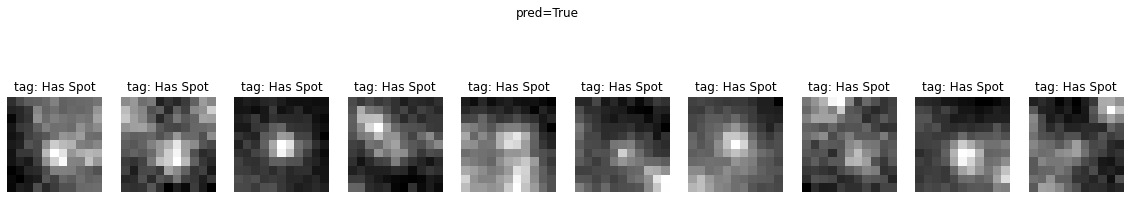

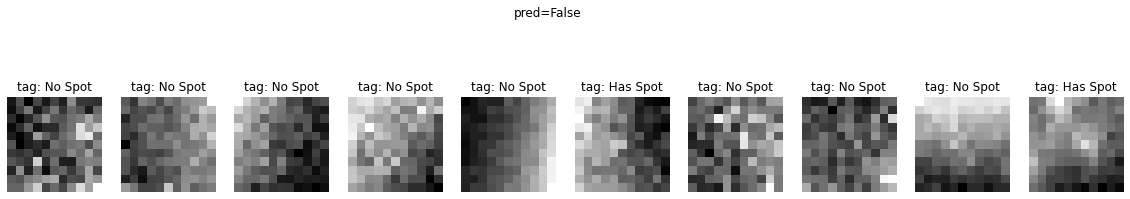

In [3]:
data_generator = ClassifierValidationDataGenerator()
all_images, tags = data_generator.get_next_batch()
shuffled_indexes = np.arange(len(all_images))
np.random.shuffle(shuffled_indexes)
images = np.array([all_images[i] for i in shuffled_indexes[:100]])
tags = np.array([tags[i] for i in shuffled_indexes[:100]])
has_point_list, result_channels_list = classify_roi_list(images)

assert(len(images) == len(tags))
assert(len(images) == len(has_point_list))

fig,axes = plt.subplots(1,10,figsize=(20,4))
fig.suptitle(f"pred={True}")
axes_has_point_iter = iter(axes)

fig,axes = plt.subplots(1,10,figsize=(20,4))
fig.suptitle(f"pred={False}")
axes_no_point_iter = iter(axes)

for i in range(len(has_point_list)):
    if tags[i][0] == 1:
        tag_text = "tag: Has Spot"
    else:
        tag_text = "tag: No Spot"
    
    if has_point_list[i]:
        ch = np.argmax(tags[i][1:])
        try:
            ax = next(axes_has_point_iter)
        except StopIteration as e:
            continue
        ax.imshow(np.max(images[i][...,ch],axis=-1),cmap="gray")
        
    if not has_point_list[i]:
        ch = np.argmax(tags[i][1:])
        try:
            ax = next(axes_no_point_iter)
        except StopIteration as e:
            continue
        ax.imshow(np.max(images[i][...,ch],axis=-1),cmap="gray")
        
    ax.set_title(f"{tag_text}")
    ax.grid(False)
    ax.axis('off')
        